In [1]:
!pip install git+https://github.com/neelnanda-io/TransformerLens -q --quiet
!pip install circuitsvis -q --quiet

In [2]:
try:
    import transformer_lens
except:
    !pip install git+https://github.com/neelnanda-io/TransformerLens -q --quiet
    !pip install circuitsvis -q --quiet

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from __future__ import annotations
from dataclasses import dataclass, field
from datetime import datetime as dt
from itertools import repeat
import os
import pickle
import random
from typing import cast, Generator, Literal
from copy import deepcopy

import circuitsvis as cv
from fancy_einsum import einsum
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, tensor, Tensor, TensorType as TT
from torch.nn import functional as F
from transformer_lens import HookedTransformerConfig, HookedTransformer
from tqdm import tqdm
from typing_extensions import Self

cv.examples.hello("You")

In [4]:
# Variable hyperparameters
MIN_LIST_LENGTH = 2
MAX_LIST_LENGTH = 50

# Context length: [start, *(unsorted_)list_length, mid, *(sorted_)list_length]
N_CTX = 2 * MAX_LIST_LENGTH + 2

# Size of vocabulary
D_VOCAB = 66

# Should lists have repetitions?
ALLOW_REPETITIONS = False

# Attention only? (False -> model includes MLPs)
ATTN_ONLY = True

# Model dimenions
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 128
D_HEAD = 32
D_MLP = None

if ATTN_ONLY:
    D_MLP = None

# Default batch size
DEFAULT_BATCH_SIZE = 32

# If you want to use pretrained weights, replace None by the path to the pkl file.
path_pkl_pretrained_weights = None

In [7]:
MID_TOKEN_ID

65

In [8]:
START_TOKEN_ID

64

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE = }")

# Seeds to generate training, validation, and test data
TRAIN_SEED = 42
VAL_SEED = 66
TEST_SEED = 1729


# "Real" tokens range from 0 to D_VOCAB - 2 (non-inclusive)
VOCAB_MIN_ID = 0
VOCAB_MAX_ID = D_VOCAB - 2

# START token is D_VOCAB - 2 and MID token is D_VOCAB - 1
START_TOKEN_ID = D_VOCAB - 2
MID_TOKEN_ID = D_VOCAB - 1

DEVICE = 'cpu'


In [10]:
VOCAB_MAX_ID

64

In [11]:
from torch.nn.utils.rnn import pad_sequence

In [12]:
PADDING_VALUE = -1

In [13]:
# Function to generate lists with variable length
def generate_list(batch_size: int) -> Tuple[Tensor, Tensor]:
    lengths = torch.randint(MIN_LIST_LENGTH, MAX_LIST_LENGTH + 1, (batch_size,))
    lists = [torch.randperm(VOCAB_MAX_ID)[:length] for length in lengths]
    return pad_sequence(lists, batch_first=True, padding_value=PADDING_VALUE).to(DEVICE), lengths

# General generator
def make_data_gen(
    *,
    batch_size: int = DEFAULT_BATCH_SIZE,
    dataset: Literal["train", "val", "test"],
) -> Generator[Tensor, None, None]:
    assert dataset in ("train", "val", "test")
    seed = TRAIN_SEED if dataset == "train" else VAL_SEED if dataset == "val" else TEST_SEED
    torch.manual_seed(seed)
    
    while True:
        x_padded, lengths = generate_list(batch_size)
        
        # Compute sorted x without considering padding value 
        x_without_padding = [x_padded[i, :length] for i, length in enumerate(lengths)]
        x_sorted = [torch.sort(xi)[0] for xi in x_without_padding]
        x_sorted_padded = pad_sequence(x_sorted, batch_first=True, padding_value=PADDING_VALUE).to(DEVICE)

        # Create sequences
        x_start = START_TOKEN_ID * torch.ones(batch_size, 1, dtype=torch.long).to(DEVICE)
        x_mid = MID_TOKEN_ID * torch.ones(batch_size, 1, dtype=torch.long).to(DEVICE)

        sequences = []
        for i in range(batch_size):
            unsorted_list = x_without_padding[i]
            sorted_list = x_sorted[i]
            length = len(unsorted_list)
            padded_length = sorted_list.numel() - unsorted_list.numel()
            
            # Concatenate start token, unsorted list, mid token, sorted list
            sequence = torch.cat(
                [x_start[i], unsorted_list, x_mid[i], sorted_list,
                torch.full((max(0, MAX_LIST_LENGTH - length),), PADDING_VALUE, dtype=torch.long).to(DEVICE)]
            )
            sequences.append(sequence)

        full_seq_padded = pad_sequence(sequences, batch_first=True, padding_value=PADDING_VALUE).to(DEVICE)

        yield full_seq_padded

# Training data generator (kinda wrapper)
def make_train_gen() -> Generator[Tensor, None, None]:
    """Make generator of training data"""
    return make_data_gen(batch_size=128, dataset="train")

# Validation and test data
val_data = next(make_data_gen(batch_size=1000, dataset="val"))
test_data = next(make_data_gen(batch_size=1000, dataset="test"))

# Let's print one example to verify
print(val_data[1])
print(val_data[1].shape)

tensor([64,  3, 38, 11, 10, 59, 31, 17, 40, 36, 50,  6,  8, 24, 30, 47, 57, 52,
        20, 16, 29, 37, 62, 61, 42, 46, 54,  7, 43, 63, 28, 60,  1, 48, 32, 34,
         2, 65,  1,  2,  3,  6,  7,  8, 10, 11, 16, 17, 20, 24, 28, 29, 30, 31,
        32, 34, 36, 37, 38, 40, 42, 43, 46, 47, 48, 50, 52, 54, 57, 59, 60, 61,
        62, 63, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
torch.Size([102])


In [14]:
import torch
from torch import Tensor

def loss_fn(
    logits: Tensor,  # [batch, pos, d_vocab]
    tokens: Tensor,  # [batch, pos]
    lengths: Tensor,  # [batch] - lengths of each sequence
    padding_value: int = -1,
    return_per_token: bool = False
) -> Tensor:  # scalar
    """
    Compute the loss for a variable-length problem, considering padding tokens.
    - Ignore padding tokens in the loss computation.
    """
    # Get the batch size and sequence length
    batch_size, seq_length = tokens.size()

    # Initialize a tensor to store the correct log probabilities for each batch
    correct_log_probs_list = []
    mask_list = []

    for i in range(batch_size):
        # Get the length of the sequence without padding
        seq_len = lengths[i].item()

        # Slice logits and tokens
        logits_sorted = logits[i, :seq_len]
        tokens_sorted = tokens[i, :seq_len]

        # Compute log probabilities
        log_probs_sorted = logits_sorted.log_softmax(-1)

        # Get the correct log probabilities for the sorted part, ignoring padding positions
        correct_log_probs = log_probs_sorted.gather(-1, tokens_sorted[..., None])[..., 0]

        # Generate mask for non-padding tokens
        mask = (tokens_sorted != padding_value).float()

        # Append to list
        correct_log_probs_list.append(correct_log_probs * mask)
        mask_list.append(mask)

    # Stack the correct log probabilities and masks to get a tensor of shape [batch, variable_pos]
    correct_log_probs_tensor = torch.cat(correct_log_probs_list)
    mask_tensor = torch.cat(mask_list)

    if return_per_token:
        # Divide only by the number of non-padding tokens
        num_non_padding_tokens = mask_tensor.sum()
        return -correct_log_probs_tensor.sum() / num_non_padding_tokens
    else:
        # Element-wise mean of the correct log probs, ignoring paddings
        return -correct_log_probs_tensor.sum() / mask_tensor.sum()

# Example usage:
# Assuming `logits`, `tokens`, and `lengths` are provided from the model output and data loader
# logits: [batch_size, sequence_length, d_vocab]
# tokens: [batch_size, sequence_length]
# lengths: [batch_size]


test = """
# Create some example data to test the function
logits = torch.randn(3, 42, 66)  # example logits with batch_size 3, seq_length 42, d_vocab 66
tokens = torch.tensor([
    [64, 3, 38, 11, 10, 59, 31, 17, 40, 36, 50, 65, 3, 10, 11, 17, 31, 36, 38, 40, 50, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [12, 52, 24, 36, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [65, 50, 36, 40, 10, 3, 59, 38, 11, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
]) 
lengths = torch.tensor([21, 4, 9])

# Compute the loss
loss = loss_fn(logits, tokens, lengths)
print(loss)"""


In [15]:
from typing import Literal
from torch import Tensor

def acc_fn(
    logits: Tensor,  # [batch, pos, d_vocab]
    tokens: Tensor,  # [batch, pos]
    lengths: Tensor,  # [batch]
    padding_value: int = -1,
    per: Literal["token", "sequence"] = "sequence"
) -> float:
    """Compute accuracy as percentage of correct predictions."""
    batch_size, seq_length = tokens.size()

    total_correct = 0
    total_tokens = 0
    total_sequences = 0
    correct_sequences = 0

    for i in range(batch_size):
        length = lengths[i].item()

        # Slicing logits and tokens to exclude padding regions and only consider valid lengths
        logits_sorted = logits[i, 1 + length + 1:1 + 2 * length + 1]  # [START | unsorted | MID | sorted | PADDING]
        tokens_sorted = tokens[i, 1 + length + 1:1 + 2 * length + 1]

        preds = logits_sorted.argmax(-1)

        if per == "sequence":
            is_sequence_correct = (preds == tokens_sorted).all().item()
            correct_sequences += is_sequence_correct
            total_sequences += 1
        else:
            mask = (tokens_sorted != padding_value)
            correct_tokens = (preds == tokens_sorted) * mask
            total_correct += correct_tokens.sum().item()
            total_tokens += mask.sum().item()

    if per == "sequence":
        return correct_sequences / total_sequences if total_sequences > 0 else 0.0
    else:
        return total_correct / total_tokens if total_tokens > 0 else 0.0

# Example tensors for testing
import torch
logits = torch.randn(3, 42, 66)  # Example logits with batch_size 3, seq_length 42, d_vocab 66
tokens = torch.tensor([
    [64, 3, 38, 11, 10, 59, 31, 17, 40, 36, 50, 65, 3, 10, 11, 17, 31, 36, 38, 40, 50, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [12, 52, 24, 36, 65, 12, 24, 36, 52, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [65, 50, 36, 40, 10, 3, 59, 38, 11, 65, 3, 10, 11, 17, 31, 36, 38, 40, 50, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
])
lengths = torch.tensor([11, 4, 9])

# Compute the accuracy
accuracy_seq = acc_fn(logits, tokens, lengths, per="sequence")
print(f"Sequence Accuracy: {accuracy_seq:.2%}")

accuracy_token = acc_fn(logits, tokens, lengths, per="token")
print(f"Token Accuracy: {accuracy_token:.2%}")

Sequence Accuracy: 0.00%
Token Accuracy: 0.00%


In [16]:
batch_size = 3
seq_length = 42
d_vocab = 66

# Create tokens with sorted parts aligned
tokens = torch.tensor([
    [64, 3, 38, 11, 10, 59, 31, 17, 40, 36, 50, 65, 3, 10, 11, 17, 31, 36, 38, 40, 50, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [12, 52, 24, 36, 65, 12, 24, 36, 52, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [65, 50, 36, 40, 10, 3, 59, 38, 11, 65, 3, 10, 11, 17, 31, 36, 38, 40, 50, 59, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
]).long()

# Lengths for the sorted and unsorted lists for each sequence in the batch
lengths = torch.tensor([11, 4, 9])

# Logits array shaped [batch_size, seq_length, d_vocab]
logits = torch.full((batch_size, seq_length, d_vocab), -100.0)  # Initialize with low logit values

for i in range(batch_size):
    length = lengths[i].item()
    sorted_start_pos = 1 + length + 1
    
    # Set high logits to ensure correct predictions
    for j in range(length):
        tokens_val = tokens[i, sorted_start_pos + j].item()  # Get the token value to match
        logits[i, sorted_start_pos + j, tokens_val] = 10.0   # Assign high logit to correct token

# Compute the accuracy
accuracy_seq = acc_fn(logits, tokens, lengths, per="sequence")
print(f"Sequence Accuracy: {accuracy_seq:.2%}")

accuracy_token = acc_fn(logits, tokens, lengths, per="token")
print(f"Token Accuracy: {accuracy_token:.2%}")

Sequence Accuracy: 33.33%
Token Accuracy: 100.00%


In [17]:
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=N_CTX,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=42,
    device=DEVICE,
    attn_only=ATTN_ONLY
)
model = HookedTransformer(cfg, move_to_device=True)

In [18]:
n_epochs = 20000

In [19]:
@dataclass(frozen=True)
class TrainingHistory:
    losses: List[float]
    train_accuracies: List[float]
    val_accuracies: List[float]

def converged(val_accs: List[float], n_last: int = 10) -> bool:
    return cast(bool, (torch.tensor(val_accs[-n_last:]) == 1).all().item())

def generate_list(batch_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
    lengths = torch.randint(MIN_LIST_LENGTH, MAX_LIST_LENGTH + 1, (batch_size,))
    lists = [torch.randperm(VOCAB_MAX_ID)[:length] for length in lengths]
    return pad_sequence(lists, batch_first=True, padding_value=PADDING_VALUE).to(DEVICE), lengths

def make_data_gen(batch_size: int, dataset: str) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    assert dataset in ("train", "val", "test")
    seed = 0 if dataset == "train" else 1 if dataset == "val" else 2  # Simplified seeds
    torch.manual_seed(seed)

    while True:
        x_padded, lengths = generate_list(batch_size)

        x_without_padding = [x_padded[i, :length] for i, length in enumerate(lengths)]
        x_sorted = [torch.sort(xi)[0] for xi in x_without_padding]
        x_sorted_padded = pad_sequence(x_sorted, batch_first=True, padding_value=PADDING_VALUE).to(DEVICE)

        x_start = START_TOKEN_ID * torch.ones(batch_size, 1, dtype=torch.long).to(DEVICE)
        x_mid = MID_TOKEN_ID * torch.ones(batch_size, 1, dtype=torch.long).to(DEVICE)

        sequences = []
        lengths_seq = []
        for i in range(batch_size):
            unsorted_list = x_without_padding[i]
            sorted_list = x_sorted[i]
            length = len(unsorted_list)

            sequence = torch.cat(
                [x_start[i], unsorted_list, x_mid[i], sorted_list,
                torch.full((MAX_LIST_LENGTH - length,), PADDING_VALUE, dtype=torch.long).to(DEVICE)]
            )
            sequences.append(sequence)
            lengths_seq.append(length)

        full_seq_padded = pad_sequence(sequences, batch_first=True, padding_value=PADDING_VALUE).to(DEVICE)
        yield full_seq_padded, torch.tensor(lengths_seq).to(DEVICE)

def make_train_gen() -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    return make_data_gen(batch_size=128, dataset="train")

# Taking length info along with val_data
val_data = next(make_data_gen(batch_size=1000, dataset="val"))

print(val_data[0][1])
print(val_data[0][1].shape)
print(val_data[1][1])  # Checking the lengths

def train_model(model: HookedTransformer) -> TrainingHistory:
    model.to(DEVICE)
    lr = 1e-4  # Reduced from 1e-3
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=100)

    losses = []
    train_accuracies = []
    val_accuracies = []

    train_gen = make_train_gen()

    for epoch in range(n_epochs):
        tokens, lengths = next(train_gen)

        logits = model(tokens)

        loss = loss_fn(logits, tokens, lengths)
        loss.backward()
        optim.step()
        optim.zero_grad()
        scheduler.step(loss)

        if epoch % 100 == 0:
            losses.append(loss.item())
            train_batch_acc = acc_fn(logits, tokens, lengths)
            val_acc, val_loss = validate_model(model, val_data)

            train_accuracies.append(train_batch_acc)
            val_accuracies.append(val_acc)
            print(
                f"Epoch {epoch}/{n_epochs} ({epoch / n_epochs:.0%}) : "
                f"loss = {loss.item():.4f}; {train_batch_acc=:.3%}; "
                f"{val_acc=:.3%}; lr={scheduler._last_lr[0]}"  # type:ignore
            )
            if converged(val_accuracies):
                print(f"\nAchieved consistent perfect validation accuracy after {epoch} epochs")
                break

    return TrainingHistory(losses, train_accuracies, val_accuracies)

def validate_model(model: HookedTransformer, val_data: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[float, float]:
    val_tokens, val_lengths = val_data
    val_logits = model(val_tokens.to(DEVICE))
    val_loss = loss_fn(val_logits, val_tokens.to(DEVICE), val_lengths.to(DEVICE))
    val_acc = acc_fn(val_logits, val_tokens.to(DEVICE), val_lengths.to(DEVICE))
    return val_acc, val_loss.item()

def load_model_state(model: HookedTransformer, filename: str) -> None:
    assert os.path.isdir("models"), "Make a directory `models` with model state dicts"
    if not filename.startswith("models/"):
        filename = f"models/{filename}"
    with open(filename, "rb") as f:
        state_dict = pickle.load(f)
    model.load_state_dict(state_dict)

tensor([64, 33, 62, 11, 41, 18, 61, 39, 59, 45, 29, 40, 43, 13, 49, 26,  9, 53,
        63, 51, 23, 52, 24,  5, 35, 16, 60, 65,  5,  9, 11, 13, 16, 18, 23, 24,
        26, 29, 33, 35, 39, 40, 41, 43, 45, 49, 51, 52, 53, 59, 60, 61, 62, 63,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])
torch.Size([102])
tensor(26)


In [20]:
val_data[0].shape

torch.Size([1000, 102])

In [21]:

train_gen = make_data_gen(batch_size=128, dataset="train")


if path_pkl_pretrained_weights:
  load_model_state(model, path_pkl_pretrained_weights)
else:
  history = train_model(model)

Moving model to device:  cpu
Epoch 0/20000 (0%) : loss = 4.5133; train_batch_acc=0.000%; val_acc=0.000%; lr=0.0001
Epoch 100/20000 (0%) : loss = 2.7955; train_batch_acc=0.000%; val_acc=0.200%; lr=0.0001
Epoch 200/20000 (1%) : loss = 1.2673; train_batch_acc=37.500%; val_acc=36.700%; lr=0.0001
Epoch 300/20000 (2%) : loss = 0.3909; train_batch_acc=77.344%; val_acc=84.000%; lr=0.0001
Epoch 400/20000 (2%) : loss = 0.1461; train_batch_acc=96.875%; val_acc=93.700%; lr=0.0001
Epoch 500/20000 (2%) : loss = 0.0753; train_batch_acc=92.188%; val_acc=96.000%; lr=0.0001
Epoch 600/20000 (3%) : loss = 0.0474; train_batch_acc=96.094%; val_acc=96.500%; lr=0.0001
Epoch 700/20000 (4%) : loss = 0.0336; train_batch_acc=95.312%; val_acc=96.900%; lr=0.0001
Epoch 800/20000 (4%) : loss = 0.0256; train_batch_acc=95.312%; val_acc=97.100%; lr=0.0001
Epoch 900/20000 (4%) : loss = 0.0199; train_batch_acc=98.438%; val_acc=97.300%; lr=0.0001
Epoch 1000/20000 (5%) : loss = 0.0164; train_batch_acc=91.406%; val_acc=97.70

KeyboardInterrupt: 

In [29]:
def show_mispreds(model: HookedTransformer, data: Tuple[Tensor, Tensor], lengths: Tensor) -> None:
    tokens, lengths = data
    logits = model(tokens)
    preds = logits.argmax(-1)  # Get the predictions by taking the argmax over the vocab dimension

    for i in range(tokens.size(0)):
        length = lengths[i].item()
        sorted_start_pos = 1 + length + 1  # Position where sorted sequence starts

        # Actual sorted tokens
        actual_sorted = tokens[i, sorted_start_pos:sorted_start_pos+length]
        
        # Predicted sorted tokens
        predicted_sorted = preds[i, sorted_start_pos:sorted_start_pos+length]
        
        # Calculate mask for padding values
        mask = (actual_sorted != PADDING_VALUE)

        # Check if there is any mismatch
        if not (predicted_sorted == actual_sorted).all().item():
            print(f"Batch index {i}:")
            print(f"Unsorted: {tokens[i, 1:length+1]}")
            print(f"Expected Sorted: {actual_sorted[mask]}")
            print(f"Predicted Sorted: {predicted_sorted[mask]}\n")

# Assuming the rest of the code remains the same

print("Validating on validation data:")
val_acc = validate_model(model, val_data)[0]
print(f"\t{val_acc=:.3%}\n")
if val_acc < 1:
    show_mispreds(model, val_data, val_data[1])

print("\nValidating on test data:")
test_acc = validate_model(model, test_data)[0]
print(f"\t{test_acc=:.3%}\n")
if test_acc < 1:
    show_mispreds(model, test_data, test_data[1])

Validating on validation data:
	val_acc=98.500%

Batch index 73:
Unsorted: tensor([50, 43, 38, 19,  5, 16, 57, 21,  1, 35, 41, 36,  4, 46,  3, 54, 29,  0,
        40, 18, 30, 14, 17,  6, 58,  7, 48, 10,  8, 20, 56, 44])
Expected Sorted: tensor([ 0,  1,  3,  4,  5,  6,  7,  8, 10, 14, 16, 17, 18, 19, 20, 21, 29, 30,
        35, 36, 38, 40, 41, 43, 44, 46, 48, 50, 54, 56, 57, 58])
Predicted Sorted: tensor([ 0,  1,  3,  4,  5,  6,  7,  8, 10, 14, 16, 17, 18, 19, 20, 21, 29, 30,
        35, 36, 38, 40, 41,  3, 44, 46, 48, 50, 54, 56, 57, 58])

Batch index 211:
Unsorted: tensor([37, 47, 58, 30, 11, 28, 63, 27, 38, 39, 55, 40, 54, 24, 18, 34, 59, 49,
        12, 48, 19,  9,  7,  4, 10, 46, 15, 21, 51, 22,  1, 25, 23, 31, 62, 57,
        53])
Expected Sorted: tensor([ 1,  4,  7,  9, 10, 11, 12, 15, 18, 19, 21, 22, 23, 24, 25, 27, 28, 30,
        31, 34, 37, 38, 39, 40, 46, 47, 48, 49, 51, 53, 54, 55, 57, 58, 59, 62,
        63])
Predicted Sorted: tensor([ 1,  4,  7,  9, 10, 11, 12, 15, 18, 19

ValueError: too many values to unpack (expected 2)

In [ ]:
test_data

In [28]:
val_acc, val_loss = validate_model(model, test_data)
print(val_acc)

ValueError: too many values to unpack (expected 2)

In [ ]:
test_data = next(make_data_gen(batch_size=1000, dataset="test"))

In [27]:
val_data[0][73]

tensor([64, 50, 43, 38, 19,  5, 16, 57, 21,  1, 35, 41, 36,  4, 46,  3, 54, 29,
         0, 40, 18, 30, 14, 17,  6, 58,  7, 48, 10,  8, 20, 56, 44, 65,  0,  1,
         3,  4,  5,  6,  7,  8, 10, 14, 16, 17, 18, 19, 20, 21, 29, 30, 35, 36,
        38, 40, 41, 43, 44, 46, 48, 50, 54, 56, 57, 58, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [31]:
test_data = next(make_data_gen(batch_size=1000, dataset="test"))
test_acc, test_loss = validate_model(model, test_data)
print(test_acc)

0.982


List Length: 2 -> Accuracy: 100.00%
List Length: 3 -> Accuracy: 100.00%
List Length: 4 -> Accuracy: 100.00%
List Length: 5 -> Accuracy: 100.00%
List Length: 6 -> Accuracy: 100.00%
List Length: 7 -> Accuracy: 100.00%
List Length: 8 -> Accuracy: 100.00%
List Length: 9 -> Accuracy: 100.00%
List Length: 10 -> Accuracy: 100.00%
List Length: 11 -> Accuracy: 100.00%
List Length: 12 -> Accuracy: 100.00%
List Length: 13 -> Accuracy: 100.00%
List Length: 14 -> Accuracy: 100.00%
List Length: 15 -> Accuracy: 100.00%
List Length: 16 -> Accuracy: 100.00%
List Length: 17 -> Accuracy: 100.00%
List Length: 18 -> Accuracy: 100.00%
List Length: 19 -> Accuracy: 100.00%
List Length: 20 -> Accuracy: 100.00%
List Length: 21 -> Accuracy: 100.00%
List Length: 22 -> Accuracy: 100.00%
List Length: 23 -> Accuracy: 100.00%
List Length: 24 -> Accuracy: 100.00%
List Length: 25 -> Accuracy: 100.00%
List Length: 26 -> Accuracy: 100.00%
List Length: 27 -> Accuracy: 100.00%
List Length: 28 -> Accuracy: 100.00%
List Leng

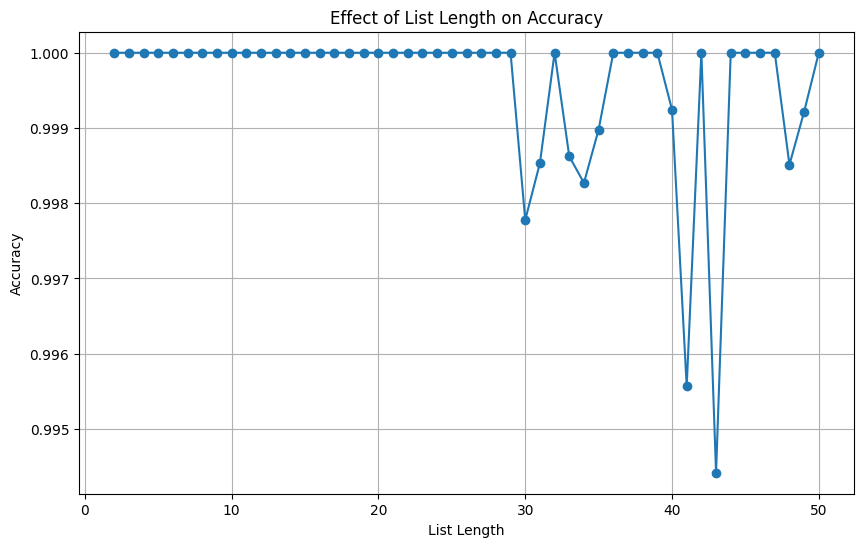

In [32]:
import matplotlib.pyplot as plt

def acc_per_length(
    model: HookedTransformer,
    logits: Tensor,
    tokens: Tensor,
    lengths: Tensor,
    padding_value: int = -1
) -> Dict[int, float]:
    """Compute accuracy for each list length."""
    length_accs = {}
    length_counts = {}

    batch_size = tokens.size(0)

    for i in range(batch_size):
        length = lengths[i].item()
        logits_sorted = logits[i, 1 + length + 1:1 + 2 * length + 1]
        tokens_sorted = tokens[i, 1 + length + 1:1 + 2 * length + 1]

        preds = logits_sorted.argmax(-1)
        mask = (tokens_sorted != padding_value)
        correct_tokens = (preds == tokens_sorted) * mask

        if length not in length_accs:
            length_accs[length] = 0
            length_counts[length] = 0

        length_accs[length] += correct_tokens.sum().item()
        length_counts[length] += mask.sum().item()

    for length in length_accs:
        length_accs[length] /= length_counts[length]
    
    return length_accs

# Assuming `model`, `test_data` are available
test_tokens, test_lengths = test_data
test_logits = model(test_tokens.to(DEVICE))
length_accuracies = acc_per_length(model, test_logits, test_tokens.to(DEVICE), test_lengths)

# Print length accuracies
for length, acc in sorted(length_accuracies.items()):
    print(f"List Length: {length} -> Accuracy: {acc:.2%}")

# Plotting the effect of list length on accuracy
def plot_length_accuracies(length_accuracies: Dict[int, float]):
    lengths = sorted(length_accuracies.keys())
    accuracies = [length_accuracies[length] for length in lengths]

    plt.figure(figsize=(10, 6))
    plt.plot(lengths, accuracies, marker='o')
    plt.xlabel('List Length')
    plt.ylabel('Accuracy')
    plt.title('Effect of List Length on Accuracy')
    plt.grid(True)
    plt.show()

plot_length_accuracies(length_accuracies)

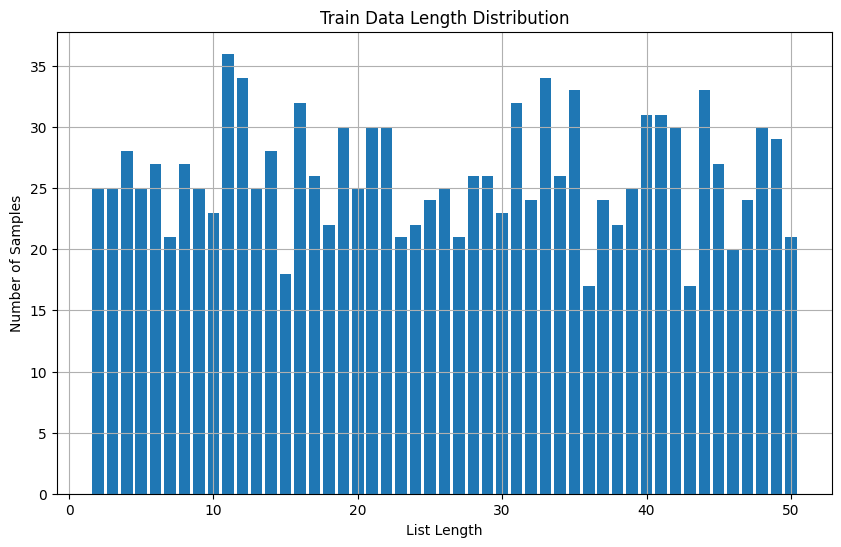

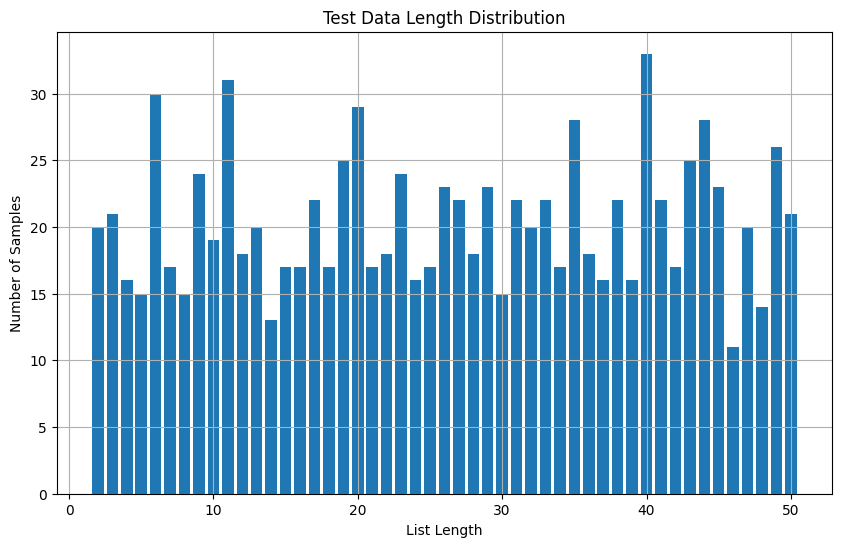

In [33]:
import matplotlib.pyplot as plt
from typing import Dict, Generator, Tuple

def gather_length_stats(generator: Generator[Tuple[Tensor, Tensor], None, None], num_batches: int) -> Dict[int, int]:
    length_counts = {}

    for _ in range(num_batches):
        _, lengths = next(generator)
        for length in lengths:
            length = length.item()
            if length not in length_counts:
                length_counts[length] = 0
            length_counts[length] += 1

    return length_counts

# Analyzing train data
train_gen = make_data_gen(batch_size=128, dataset="train")
train_length_stats = gather_length_stats(train_gen, num_batches=10)  # Adjust based on your requirement

# Analyzing test data
test_gen = make_data_gen(batch_size=1000, dataset="test")
test_length_stats = gather_length_stats(test_gen, num_batches=1)  # Adjust based on your requirement

def plot_length_distribution(length_stats: Dict[int, int], title: str):
    lengths = sorted(length_stats.keys())
    counts = [length_stats[length] for length in lengths]

    plt.figure(figsize=(10, 6))
    plt.bar(lengths, counts)
    plt.xlabel('List Length')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Plotting train length distribution
plot_length_distribution(train_length_stats, "Train Data Length Distribution")

# Plotting test length distribution
plot_length_distribution(test_length_stats, "Test Data Length Distribution")

In [38]:
def save_model_state_dict(
    model: HookedTransformer,
    filename: str | None = None
) -> None:
    if not os.path.isdir("C:/Users/DELL/Downloads/models"):
        os.mkdir("C:/Users/DELL/Downloads/models")
    if not filename:
        timestamp = dt.now().isoformat("T", "minutes").replace(":", "-")
        filename = f"model_state_dict_{timestamp}.pkl"
    with open(f"C:/Users/DELL/Downloads/models/{filename}", "wb") as f:
        pickle.dump(model.state_dict(), f)

save_model_state_dict(model)

In [37]:
os.listdir("models")

['model_state_dict_2024-07-31T21-57.pkl',
 'model_state_dict_2024-07-31T21-59.pkl']

In [39]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [40]:
import torch
from torch import Tensor
from typing import Tuple, Generator
from torch.nn.utils.rnn import pad_sequence
from dataclasses import dataclass
import matplotlib.pyplot as plt
import circuitsvis as cv

# (Assuming other parts of your code are unchanged)

# Get one input from test_data
test_input, test_length = test_data
test_input_single = test_input[3, :].unsqueeze(0)  # reshape to add batch dimension
test_length_single = test_length[3].unsqueeze(0)  # length of the single test input
max_sorted_length = test_length_single.item()  # Maximum length after sorting

# Pass through model, get cache and predictions
logits, cache_model = model.run_with_cache(test_input_single.to(DEVICE), remove_batch_dim=False)
preds = logits[:, 1 + max_sorted_length + 1 : 1 + 2 * max_sorted_length + 1].argmax(-1)

# Get attention pattern and plot it
attention_pattern = cache_model["pattern", 0, "attn"][0]  # Get attention pattern for layer 0 head 0

# Convert tokens to their string representations
def token_to_str(token_id):
    if token_id == PADDING_VALUE:
        return "<PAD>"
   # elif token_id == START_TOKEN_ID:
    #    return "<START>"
    #elif token_id == MID_TOKEN_ID:
     #   return "<MID>"
    else:
        return str(token_id.item())

tokens_input = list(map(token_to_str, test_input_single[0]))

print("Input Tokens:", tokens_input)
print("Predicted Sorted Tokens:", preds.cpu().tolist())



Input Tokens: ['64', '11', '4', '59', '36', '38', '14', '53', '34', '1', '20', '9', '10', '35', '52', '8', '18', '3', '39', '27', '22', '24', '37', '2', '54', '32', '43', '55', '29', '58', '50', '57', '41', '65', '1', '2', '3', '4', '8', '9', '10', '11', '14', '18', '20', '22', '24', '27', '29', '32', '34', '35', '36', '37', '38', '39', '41', '43', '50', '52', '53', '54', '55', '57', '58', '59', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Predicted Sorted Tokens: [[1, 2, 3, 4, 8, 9, 10, 11, 14, 18, 20, 22, 24, 27, 29, 32, 34, 35, 36, 37, 38, 39, 41, 43, 50, 52, 53, 54, 55, 57, 58, 59]]


In [41]:
# Plotting the attention pattern
cv.attention.attention_patterns(tokens=tokens_input, attention=attention_pattern.cpu().detach().numpy())

In [ ]:
https://platform.openai.com/playground/p/a6smfu5HM5HcPWWuHim9pVOq